In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import ParameterGrid
from PIL import Image

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# Path to dataset
data_dir = r"C:\Users\Judithleochristopher\Desktop\currency\Datasets"


In [4]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load dataset
full_dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = full_dataset.classes

# Split dataset: 70% train, 15% val, 15% test
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [5]:
from tqdm import tqdm  # For progress bar
import copy

def train_and_validate(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # Training Phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_acc = correct_train / total_train
        print(f"Training Accuracy: {train_acc:.4f}")

        # Validation Phase
        model.eval()
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_acc = correct_val / total_val
        print(f"Validation Accuracy: {val_acc:.4f}")

        # Save best model weights
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    # Load best weights before returning
    model.load_state_dict(best_model_wts)
    return model, best_val_acc


In [6]:
from sklearn.model_selection import ParameterGrid
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy

# Define hyperparameter grid
param_grid = {'lr': [0.001, 0.0005, 0.0001]}
results = {}
best_model = None
best_lr = None
best_acc = 0.0

for params in ParameterGrid(param_grid):
    print(f"\nTraining with learning rate: {params['lr']}")
    
    # Load EfficientNet model
    model = models.efficientnet_b3(weights="IMAGENET1K_V1")
    
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Modify the classifier
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, len(class_names))
    model = model.to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier[1].parameters(), lr=params['lr'])

    # Train and validate
    model, acc = train_and_validate(model, criterion, optimizer, train_loader, val_loader, num_epochs=5)

    results[f"lr={params['lr']}"] = acc

    # Track best model
    if acc > best_acc:
        best_acc = acc
        best_model = copy.deepcopy(model)
        best_lr = params['lr']
        torch.save(best_model.state_dict(), "best_modell1.pth")

# Report results
print("\nHyperparameter Tuning Results:")
for k, v in results.items():
    print(f"{k} -> Accuracy: {v:.4f}")

print(f"\n✅ Best Learning Rate: {best_lr}")
print(f"🎯 Best Validation Accuracy: {best_acc:.4f}")



Training with learning rate: 0.001

Epoch 1/5
--------------------


Training: 100%|██████████| 59/59 [04:29<00:00,  4.56s/it]


Training Accuracy: 0.4373


Validation: 100%|██████████| 13/13 [00:51<00:00,  3.99s/it]


Validation Accuracy: 0.7232

Epoch 2/5
--------------------


Training: 100%|██████████| 59/59 [04:07<00:00,  4.19s/it]


Training Accuracy: 0.7397


Validation: 100%|██████████| 13/13 [00:47<00:00,  3.64s/it]


Validation Accuracy: 0.7855

Epoch 3/5
--------------------


Training: 100%|██████████| 59/59 [04:03<00:00,  4.14s/it]


Training Accuracy: 0.8197


Validation: 100%|██████████| 13/13 [00:47<00:00,  3.62s/it]


Validation Accuracy: 0.8279

Epoch 4/5
--------------------


Training: 100%|██████████| 59/59 [03:58<00:00,  4.04s/it]


Training Accuracy: 0.8507


Validation: 100%|██████████| 13/13 [00:45<00:00,  3.48s/it]


Validation Accuracy: 0.8753

Epoch 5/5
--------------------


Training: 100%|██████████| 59/59 [03:56<00:00,  4.00s/it]


Training Accuracy: 0.8624


Validation: 100%|██████████| 13/13 [00:45<00:00,  3.48s/it]


Validation Accuracy: 0.8678

Training with learning rate: 0.0005

Epoch 1/5
--------------------


Training: 100%|██████████| 59/59 [03:59<00:00,  4.06s/it]


Training Accuracy: 0.3051


Validation: 100%|██████████| 13/13 [00:45<00:00,  3.52s/it]


Validation Accuracy: 0.5711

Epoch 2/5
--------------------


Training: 100%|██████████| 59/59 [03:59<00:00,  4.06s/it]


Training Accuracy: 0.6149


Validation: 100%|██████████| 13/13 [00:45<00:00,  3.52s/it]


Validation Accuracy: 0.7082

Epoch 3/5
--------------------


Training: 100%|██████████| 59/59 [03:58<00:00,  4.04s/it]


Training Accuracy: 0.7168


Validation: 100%|██████████| 13/13 [00:45<00:00,  3.47s/it]


Validation Accuracy: 0.7880

Epoch 4/5
--------------------


Training: 100%|██████████| 59/59 [03:57<00:00,  4.02s/it]


Training Accuracy: 0.7936


Validation: 100%|██████████| 13/13 [00:45<00:00,  3.53s/it]


Validation Accuracy: 0.7880

Epoch 5/5
--------------------


Training: 100%|██████████| 59/59 [03:58<00:00,  4.04s/it]


Training Accuracy: 0.8101


Validation: 100%|██████████| 13/13 [00:45<00:00,  3.52s/it]


Validation Accuracy: 0.8254

Training with learning rate: 0.0001

Epoch 1/5
--------------------


Training: 100%|██████████| 59/59 [03:58<00:00,  4.05s/it]


Training Accuracy: 0.1541


Validation: 100%|██████████| 13/13 [00:45<00:00,  3.50s/it]


Validation Accuracy: 0.2319

Epoch 2/5
--------------------


Training: 100%|██████████| 59/59 [03:58<00:00,  4.04s/it]


Training Accuracy: 0.2971


Validation: 100%|██████████| 13/13 [00:45<00:00,  3.53s/it]


Validation Accuracy: 0.3666

Epoch 3/5
--------------------


Training: 100%|██████████| 59/59 [04:01<00:00,  4.10s/it]


Training Accuracy: 0.3947


Validation: 100%|██████████| 13/13 [00:47<00:00,  3.64s/it]


Validation Accuracy: 0.4564

Epoch 4/5
--------------------


Training: 100%|██████████| 59/59 [04:05<00:00,  4.17s/it]


Training Accuracy: 0.4741


Validation: 100%|██████████| 13/13 [00:47<00:00,  3.62s/it]


Validation Accuracy: 0.5362

Epoch 5/5
--------------------


Training: 100%|██████████| 59/59 [04:06<00:00,  4.18s/it]


Training Accuracy: 0.5531


Validation: 100%|██████████| 13/13 [00:47<00:00,  3.63s/it]

Validation Accuracy: 0.5860

Hyperparameter Tuning Results:
lr=0.001 -> Accuracy: 0.8753
lr=0.0005 -> Accuracy: 0.8254
lr=0.0001 -> Accuracy: 0.5860

✅ Best Learning Rate: 0.001
🎯 Best Validation Accuracy: 0.8753


In [7]:
# Try a new learning rate: 0.01
print("\n🔍 Trying extra learning rate: 0.01")

# Load model
model_extra = models.efficientnet_b3(weights="IMAGENET1K_V1")
for param in model_extra.parameters():
    param.requires_grad = False

in_features = model_extra.classifier[1].in_features
model_extra.classifier[1] = nn.Linear(in_features, len(class_names))
model_extra = model_extra.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_extra.classifier[1].parameters(), lr=0.01)

# Train and validate
model_extra, acc_extra = train_and_validate(model_extra, criterion, optimizer, train_loader, val_loader, num_epochs=5)

print(f"📊 Accuracy with lr=0.01: {acc_extra:.4f}")

# Compare with best so far
if acc_extra > best_acc:
    print(" New best learning rate found: 0.01")
    best_model = model_extra
    best_lr = 0.01
    best_acc = acc_extra
    torch.save(best_model.state_dict(), "best_modell1.pth")
else:
    print("✅ The original best model remains unchanged.")



🔍 Trying extra learning rate: 0.01

Epoch 1/5
--------------------


Training: 100%|██████████| 59/59 [04:10<00:00,  4.24s/it]


Training Accuracy: 0.6203


Validation: 100%|██████████| 13/13 [00:47<00:00,  3.65s/it]


Validation Accuracy: 0.8678

Epoch 2/5
--------------------


Training: 100%|██████████| 59/59 [04:08<00:00,  4.21s/it]


Training Accuracy: 0.8592


Validation: 100%|██████████| 13/13 [00:47<00:00,  3.66s/it]


Validation Accuracy: 0.8878

Epoch 3/5
--------------------


Training: 100%|██████████| 59/59 [04:07<00:00,  4.19s/it]


Training Accuracy: 0.8923


Validation: 100%|██████████| 13/13 [00:47<00:00,  3.65s/it]


Validation Accuracy: 0.9002

Epoch 4/5
--------------------


Training: 100%|██████████| 59/59 [04:08<00:00,  4.21s/it]


Training Accuracy: 0.9099


Validation: 100%|██████████| 13/13 [00:47<00:00,  3.67s/it]


Validation Accuracy: 0.8953

Epoch 5/5
--------------------


Training: 100%|██████████| 59/59 [04:08<00:00,  4.22s/it]


Training Accuracy: 0.9237


Validation: 100%|██████████| 13/13 [00:47<00:00,  3.65s/it]

Validation Accuracy: 0.9027
📊 Accuracy with lr=0.01: 0.9027
 New best learning rate found: 0.01


In [8]:
# Load best model
model = models.efficientnet_b3(weights="IMAGENET1K_V1")
for param in model.parameters():
    param.requires_grad = False
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, len(class_names))
model.load_state_dict(torch.load("best_modell1.pth"))
model = model.to(device)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [9]:
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {(100 * correct / total):.2f}%")


Test Accuracy: 91.56%


In [10]:
torch.save(model, "entire_modell1.pth")

In [19]:
import torch
from torchvision import transforms, models
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load class names (if you have them stored)
class_names = train_dataset.dataset.classes  # or manually list them if needed

# Define transform (must match your training transform)
transform = transforms.Compose([
    transforms.Resize((300, 300)),  # EfficientNetB3 expects 300x300
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load image
image_path = r"C:\Users\Judithleochristopher\Downloads\MIN10-88.jpg" # Replace with your image path
img = Image.open(image_path).convert('RGB')
img_t = transform(img)
img_t = img_t.unsqueeze(0).to(device)  # Add batch dimension

# Load the best model
model = models.efficientnet_b3(weights="IMAGENET1K_V1")
in_features = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(in_features, len(class_names))
model.load_state_dict(torch.load("best_modell1.pth"))
model = model.to(device)
model.eval()

# Make prediction
with torch.no_grad():
    output = model(img_t)
    _, predicted = torch.max(output, 1)
    predicted_class = class_names[predicted.item()]

print(f"Predicted class: {predicted_class}")



Predicted class: ten_old


In [13]:
print(class_names)

['fifty_new', 'fifty_old', 'five_hundred', 'hundred_new', 'hundred_old', 'ten_new', 'ten_old', 'twenty_new', 'twenty_old', 'two_hundred', 'two_thousand']


In [1]:
history = {
    "0.001": {
        "train_acc": [0.4373, 0.7397, 0.8197, 0.8507, 0.8624],
        "val_acc":   [0.7232, 0.7855, 0.8279, 0.8753, 0.8678]
    },
    "0.0005": {
        "train_acc": [0.3051, 0.6149, 0.7168, 0.7936, 0.8101],
        "val_acc":   [0.5711, 0.7082, 0.7880, 0.7880, 0.8254]
    },
    "0.0001": {
        "train_acc": [0.1541, 0.2971, 0.3947, 0.4741, 0.5531],
        "val_acc":   [0.2319, 0.3666, 0.4564, 0.5362, 0.5860]
    },
    "0.01": {
        "train_acc": [0.6203, 0.8592, 0.8923, 0.9099, 0.9237],
        "val_acc":   [0.8678, 0.8878, 0.9002, 0.8953, 0.9027]
    }
}


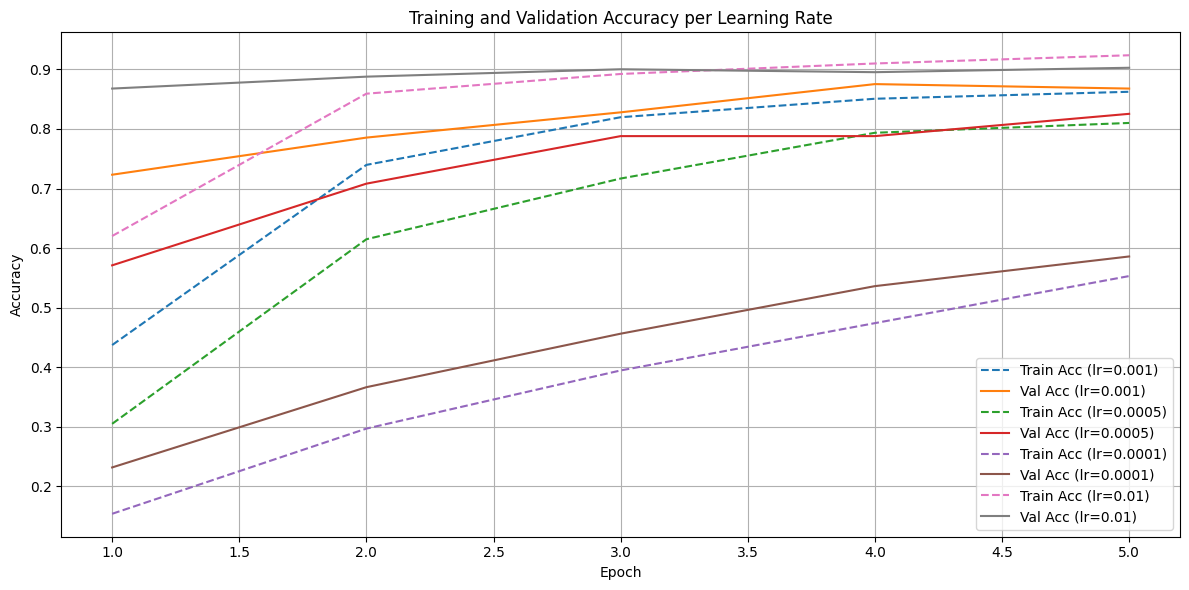

In [2]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]

plt.figure(figsize=(12, 6))
for lr, values in history.items():
    plt.plot(epochs, values["train_acc"], linestyle="--", label=f"Train Acc (lr={lr})")
    plt.plot(epochs, values["val_acc"], linestyle="-",  label=f"Val Acc (lr={lr})")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy per Learning Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


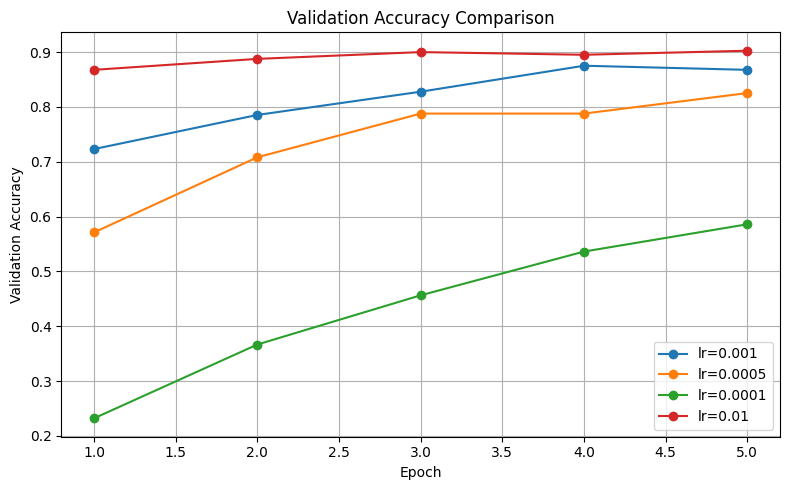

In [3]:
plt.figure(figsize=(8, 5))
for lr, values in history.items():
    plt.plot(epochs, values["val_acc"], marker="o", label=f"lr={lr}")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
